# Matched Filter Beamformer for a Rigid Sphere

In [1]:
import micarray
import irutils
import numpy as np
from micarray.util import db
from scipy.special import sph_harm
from scipy.signal import freqz, sosfilt, sosfreqz, kaiser
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
c = 343  # speed of sound
fs = 2 * 44100

# Broadband excitation
L = 1024
imp = np.zeros(L)
imp[L // 2] = 1

# Incident plane wave
sf_order = 40
azi_pw, colat_pw = np.pi, 0.5 * np.pi

# Microphone array
R = 0.25  # radius
array_order = 30
azi_q, colat_q, wq = micarray.modal.angular.grid_gauss(n=array_order)
Q = len(azi_q)

# Critical frequencies
f_sf = c * sf_order / 2 / np.pi / R
f_alias = c * array_order / 2 / np.pi / R

In [3]:
# Captured signal
delay, sos = irutils.radial_filter(sf_order, R, fs=fs, setup='rigid')
s0nm = np.column_stack([sosfilt(sos[n], imp)[:, np.newaxis]
                        * np.stack([sph_harm(m, n, azi_pw, colat_pw)
                                    for m in range(-n, n + 1)])
                        for n in range(sf_order + 1)])
s0nm *= 4 * np.pi
Ynm_s = micarray.modal.angular.sht_matrix(sf_order, azi_q, colat_q)
s0 = np.squeeze(np.matmul(Ynm_s, s0nm[:, :, np.newaxis]))

In [6]:
# Modal Analysis
bf_order = 7
if bf_order > sf_order:
    delay, sos = irutils.radial_filter(bf_order, R, fs=fs, setup='rigid')
f_N = c * bf_order / 2 / np.pi / R
Ynm_q = micarray.modal.angular.sht_matrix(bf_order, azi_q, colat_q, wq)
snm = np.squeeze(np.matmul(np.conj(Ynm_q.T), s0[:, :, np.newaxis]))

# Matched filter beamforming
N_angle = 360
azi_l, colat_l = np.linspace(-np.pi, np.pi, num=N_angle), 0.5 * np.pi
Ynm_l = micarray.modal.angular.sht_matrix(bf_order, azi_l, colat_l)
vnm = np.zeros((L, (bf_order + 1)**2), dtype='complex128')
i = 0
for n in range(bf_order + 1):
    for m in range(-n, n + 1):
        vnm[:, i] = (1)**n * sosfilt(sos[n], snm[::-1, i])
        i += 1
vnm *= 4 * np.pi
v = np.squeeze(np.matmul(Ynm_l, vnm[:, :, np.newaxis]))

# Frequency responses
fmin, fmax, num_f = 80, 15000, 500
f = np.logspace(np.log10(fmin), np.log10(fmax), num=num_f)
Omega = 2 * np.pi * f / fs
V = np.column_stack([freqz(v_i, worN=Omega)[1] for v_i in v.T])

R = 0.25 m, # of mic = 1922, array order = 30,      bf order = 7, fs = 88200


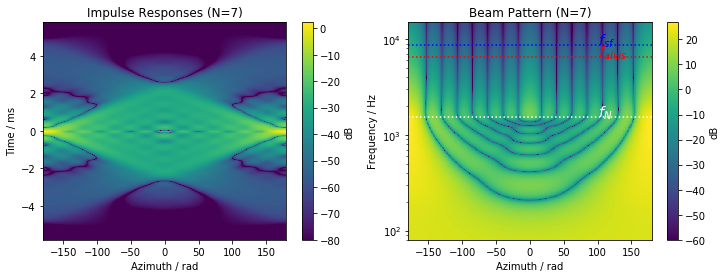

In [8]:
time = (np.arange(L) - L // 2) / fs
tlim = np.array([-R / c, R / c]) * 3 * 1000
ir_vmin = -80
tf_vmin = -60


fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

im = ax[0].pcolormesh(np.rad2deg(azi_l), time * 1000, db(v), vmin=ir_vmin)
# ax[0].set_ylim(tlim)
ax[0].set_xlabel('Azimuth / rad')
ax[0].set_ylabel('Time / ms')
fig.colorbar(im, ax=ax[0]).set_label('dB')
ax[0].set_title('Impulse Responses (N={})'.format(bf_order))

im = ax[1].pcolormesh(np.rad2deg(azi_l), f, db(V), vmin=tf_vmin)
ax[1].plot(np.rad2deg(azi_l), f_sf * np.ones_like(azi_l), 'b:')
ax[1].plot(np.rad2deg(azi_l), f_alias * np.ones_like(azi_l), 'r:')
ax[1].plot(np.rad2deg(azi_l), f_N * np.ones_like(azi_l), 'w:')
if f_sf < fmax: ax[1].text(100, f_sf, '$f_{sf}$', fontsize='x-large', color='b')
if f_alias < fmax: ax[1].text(100, f_alias, '$f_{alias}$', fontsize='x-large', color='r')
if f_N < fmax: ax[1].text(100, f_N, '$f_{N}$', fontsize='x-large', color='w')
ax[1].set_xlabel('Azimuth / rad')
ax[1].set_ylabel('Frequency / Hz')
ax[1].set_yscale('log')
ax[1].set_ylim([fmin, fmax])
fig.colorbar(im, ax=ax[1]).set_label('dB')
ax[1].set_title('Beam Pattern (N={})'.format(bf_order))

print('R = {R} m, # of mic = {Q}, array order = {array_order},\
      bf order = {bf_order}, fs = {fs}'
      .format(R=R, Q=Q, array_order=array_order, bf_order=bf_order, fs=fs))